### Toronto neighborhood data Cluster Analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Toronto_Postal_data(2).csv


Importing other dependencies

In [118]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import json
import requests
from pandas.io.json import json_normalize
import folium
import matplotlib.pyplot as plt

Reading and storing the data

In [81]:
df = pd.read_csv('/kaggle/input/Toronto_Postal_data(2).csv')

In [82]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Creating a Map of Toronto and super-imposing the Postal Codes along with their boroughs

In [83]:
# Defining latitude and longitude of Toronto

latitude = 43.6532
longitude = -79.3832

map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, pcode in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Postal Code']):
    label = '{}, {}'.format(pcode,borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  

#map_Toronto

Defining Foursquare Credentials and defining Foursquare URL
For this assignment , clustering is done on the basis of top 5 venues within a distance of 1km

In [84]:
CLIENT_ID = 'HSKSPYIMS3JWAL4IJ3IWQT1MOLT04ITR1UTIPF3OYZ220JXF' # your Foursquare ID
CLIENT_SECRET = 'YS1P0XFBMDIERG42KRRFGQHG4AYWYC4LBNIKTWLFXBLEKDKN' # your Foursquare Secret
VERSION = '20200504' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HSKSPYIMS3JWAL4IJ3IWQT1MOLT04ITR1UTIPF3OYZ220JXF
CLIENT_SECRET:YS1P0XFBMDIERG42KRRFGQHG4AYWYC4LBNIKTWLFXBLEKDKN


Defining a funtion that returns the category of the Venue

In [85]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Iterating through the dataframe getting the top venues and their categories and storing it in a new dataframe

In [86]:
df_copy=df
df_venues = pd.DataFrame(columns = ['Postal Code','Venue Name','Venue Category'])

In [87]:
for i in range(0,103):
    
    try:
        pcode = df_copy.loc[i][0]
        pcode_latitude = df_copy.loc[i][3]
        pcode_longitude = df_copy.loc[i][4]
        radius = 1000
        LIMIT = 20
        my_url =  'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            pcode_latitude, 
            pcode_longitude, 
            radius, 
            LIMIT)
        results = requests.get(my_url).json()

        venues = results['response']['groups'][0]['items']

        nearby_venues = pd.json_normalize(venues)

        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

        nearby_venues =nearby_venues.loc[:, filtered_columns]

        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        
        l = nearby_venues.shape[0]
        
        for i in range(0,l):
            df_venues = df_venues.append({'Postal Code' : pcode, 
                              'Venue Name' : nearby_venues.iloc[i][0] , 
                              'Venue Category' : nearby_venues.iloc[i][1]} , 
                            ignore_index=True)
              
    except:
        
        continue
    

In [89]:
df_venues.groupby('Postal Code').count()

,Venue Name,Venue Category
Postal Code,,
M1B,16,16
M1C,5,5
M1E,20,20
M1G,8,8
M1H,20,20
...,...,...
M9N,15,15
M9P,15,15
M9R,17,17


Using One Hot Encoding to categorize the Venue Category

In [90]:
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

df_onehot['Postal Code'] = df_venues['Postal Code'] 

fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,Postal Code,ATM,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,...,Transportation Service,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
df_grouped = df_onehot.groupby('Postal Code').mean().reset_index()
df_grouped

,Postal Code,ATM,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Art Gallery,Art Museum,Arts & Crafts Store,...,Transportation Service,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
1,M1C,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
2,M1E,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
3,M1G,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
4,M1H,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,M9N,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
98,M9P,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
99,M9R,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
100,M9V,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00


Finding the top 5 venues in each Postal Code region

In [108]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [158]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

pcode_venues_sorted = pd.DataFrame(columns=columns)
pcode_venues_sorted['Postal Code'] = df_grouped['Postal Code']

for ind in np.arange(df_grouped.shape[0]):
    pcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

pcode_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Trail,Fast Food Restaurant,Coffee Shop,Caribbean Restaurant,Chinese Restaurant
1,M1C,Breakfast Spot,Park,Burger Joint,Italian Restaurant,Playground
2,M1E,Fast Food Restaurant,Pizza Place,Coffee Shop,Bank,Restaurant
3,M1G,Coffee Shop,Park,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant
4,M1H,Indian Restaurant,Coffee Shop,Bank,Yoga Studio,Music Store


Clustering the data and finding the elbow point

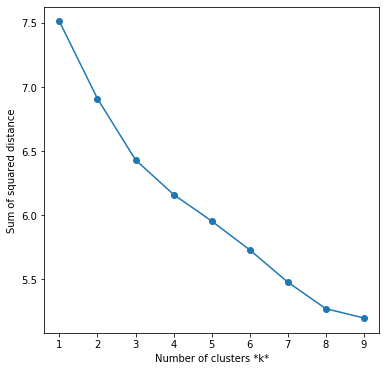

In [159]:
df_grouped_clustered = df_grouped.drop('Postal Code', 1)

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k,random_state=0)
    km.fit(df_grouped_clustered)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

The observing the plot, we can see that although no perfect elbow point exists, still using k = 3 could be a good choice

In [160]:
kclusters = 3

df_grouped_clustering = df_grouped.drop('Postal Code', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

Creating a new dataframe with the cluster labels

In [161]:
pcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df

df_merged = df_merged.join(pcode_venues_sorted.set_index('Postal Code'), on='Postal Code')

df_merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353,0.0,Trail,Fast Food Restaurant,Coffee Shop,Caribbean Restaurant,Chinese Restaurant
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,2.0,Breakfast Spot,Park,Burger Joint,Italian Restaurant,Playground
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711,0.0,Fast Food Restaurant,Pizza Place,Coffee Shop,Bank,Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Park,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Indian Restaurant,Coffee Shop,Bank,Yoga Studio,Music Store
...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188,0.0,Coffee Shop,Train Station,Furniture / Home Store,Sandwich Place,Bank
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,0.0,Pizza Place,Gas Station,Ice Cream Shop,Coffee Shop,Chinese Restaurant
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Gr...",43.688905,-79.554724,0.0,Pharmacy,Bus Line,Sandwich Place,Chinese Restaurant,Supplement Shop
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , ...",43.739416,-79.588437,0.0,Pizza Place,Grocery Store,Hardware Store,Coffee Shop,Bus Line


Convert Cluster Labels to integer

In [162]:
df_merged.dropna(inplace=True)
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype({"Cluster Labels": int})

Visualizing the data in the map of Toronto

In [163]:
latitude = 43.6532
longitude = -79.3832

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'],
                                  df_merged['Postal Code'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

Hence the Toronto Postal Codes have been clustered in 3 parts based on their top 10 venues